In [ ]:
pip install deepctr-torch

In [ ]:
import os
import re
import numpy as np
import pandas as pd

import torch
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from deepctr_torch.models import DeepFM, xDeepFM, WDL, AutoInt
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names



---


## Preparing the data (ratings, movies and subbmisions)

In [ ]:
data_path = "/kaggle/input/recsys-runi-2025/"

In [ ]:
ratings_df = pd.read_csv(data_path + "train.csv")
ratings_df.head(5)

,user_id,movie_id,rating
0,0,0,NaN
1,0,8,NaN
2,0,11,NaN
3,0,25,NaN
4,0,31,2.0


In [ ]:
ratings_df.isna().sum()

user_id            0
movie_id           0
rating      11017969
dtype: int64

In [ ]:
ratings_df.count()

user_id     18321319
movie_id    18321319
rating       7303350
dtype: int64

In [ ]:
# Remove all implicit ratings (nans)
ratings_df = ratings_df.dropna(subset=['rating'], inplace=False)

In [ ]:
ratings_df.head(5)

,user_id,movie_id,rating
4,0,31,2.0
5,0,37,4.0
6,0,38,3.0
11,0,58,3.5
17,0,160,3.5


In [ ]:
movies_df = pd.read_csv(data_path + "movies.csv")
movies_df.head(5)

,movie_id,title,genres
0,11,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,8,Jumanji (1995),Adventure|Children|Fantasy
2,9,Grumpier Old Men (1995),Comedy|Romance
3,15,Father of the Bride Part II (1995),Comedy
4,12,Heat (1995),Action|Crime|Thriller


### Process the movies data:
1. extract year from the movie title and convert it to one of the categories:
   * Old - till 1980
   * Mid - till 2000
   * New - after 2000

Converting movie years into categories like "Old," "Mid," and "New" helps capture temporal trends in user preferences, reduces feature sparsity, and improves model generalization. It simplifies the dataset, enhances interpretability, and allows the model to learn meaningful patterns more effectively.

2. Create multi-shot columns for the genres - each genre is represented with a binary column.

In [ ]:
def extract_year(title):
    match = re.search(r"\((\d{4})\)", title)
    return int(match.group(1)) if match else None

# Categorize the years
def categorize_year(year):
    if year < 1980:
        return 1
    elif 1980 <= year < 2000:
        return 2
    else:
        return 3


movies_df['year'] = movies_df['title'].apply(extract_year)
movies_df['year_category'] = movies_df['year'].apply(categorize_year)

In [ ]:
# Split the genres into multiple binary columns (one-hot encoding)
genres_columns = movies_df['genres'].str.get_dummies(sep='|')
movies_df = pd.concat([movies_df, genres_columns], axis=1)
movies_df.drop(columns=['genres', '(no genres listed)', 'year', 'title'], inplace=True)
movies_df.columns

Index(['movie_id', 'year_category', 'Action', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
       'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [ ]:
movies_df.head(5)

,movie_id,year_category,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,11,2,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,2,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,15,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,2,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
movies_df['year_category'].value_counts()

year_category
2    909
3    868
1    223
Name: count, dtype: int64



---


## Create the training datasets

In this section we will create 4 training datasets:
1. Based only on the ratings DF
2. Include years categories
3. Include genres multi-hot columns
4. Combined dataset with both year categories and genres

In [ ]:
basic_train_df = ratings_df.copy()
print(f'basic_train_df shape: {basic_train_df.shape}')
basic_train_df.head(5)

basic_train_df shape: (7303350, 3)


,user_id,movie_id,rating
4,0,31,2.0
5,0,37,4.0
6,0,38,3.0
11,0,58,3.5
17,0,160,3.5


In [ ]:
year_train_df = pd.merge(ratings_df, movies_df[['movie_id', 'year_category']], on='movie_id', how='left')
print(f'year_train_df shape: {year_train_df.shape}')
year_train_df.head(5)

year_train_df shape: (7303350, 4)


,user_id,movie_id,rating,year_category
0,0,31,2.0,2
1,0,37,4.0,2
2,0,38,3.0,2
3,0,58,3.5,2
4,0,160,3.5,2


In [ ]:
genre_cols = [col for col in movies_df.columns if col not in ['year_category']]
genre_train_df = pd.merge(ratings_df, movies_df[genre_cols], on='movie_id', how='left')
print(f'genre_train_df shape: {genre_train_df.shape}')
genre_train_df.head(5)

genre_train_df shape: (7303350, 22)


,user_id,movie_id,rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,31,2.0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,1,0,0
1,0,37,4.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,38,3.0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,58,3.5,0,0,1,1,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,160,3.5,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
combined_train_df = pd.merge(ratings_df, movies_df, on='movie_id', how='left')
print(f'combined_train_df shape: {combined_train_df.shape}')
combined_train_df.head(5)

combined_train_df shape: (7303350, 23)


,user_id,movie_id,rating,year_category,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,31,2.0,2,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
1,0,37,4.0,2,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,38,3.0,2,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,58,3.5,2,0,0,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0
4,0,160,3.5,2,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0




---


## W-RMSE implementation

The weights will be calculated outside the function, as they should be coresponded to the samples' movie_ids order.

In [ ]:
def wrmse_loss(y_true, y_pred, weights):
    numerator = torch.sum(weights * (y_true - y_pred) ** 2)
    denominator = torch.sum(weights)
    return torch.sqrt(numerator / denominator)

## Recommender DNN based model structure

In [ ]:
def train_one_epoch(model, data_loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch_features, batch_labels, batch_weights in data_loader:
        batch_features = batch_features.to(device)
        batch_labels = batch_labels.to(device)
        batch_weights = batch_weights.to(device)

        # Forward pass
        predictions = model(batch_features)  # Pass the dictionary to the model
        loss = loss_fn(predictions.squeeze(), batch_labels, batch_weights)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)


def evaluate(model, data_loader, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels, batch_weights in data_loader:
            # Reconstruct input dictionary
            batch_features = batch_features.to(device)
            batch_labels = batch_labels.to(device)
            batch_weights = batch_weights.to(device)

            # Forward pass
            predictions = model(batch_features)  # Pass the dictionary to the model
            loss = loss_fn(predictions.squeeze(), batch_labels, batch_weights)
            total_loss += loss.item()

    return total_loss / len(data_loader)

In [ ]:
def train_model(model, device, train_df, lr=0.001, epochs=5):
    # Split the data
    train, val = train_test_split(train_df, test_size=0.2, random_state=42)

    # Prepare input data
    train_model_input = {name: torch.tensor(train[name].values, dtype=torch.float32).to(device) for name in feature_names}
    val_model_input = {name: torch.tensor(val[name].values, dtype=torch.float32).to(device) for name in feature_names}

    train_labels = torch.tensor(train["rating"].values, dtype=torch.float32).to(device)
    val_labels = torch.tensor(val["rating"].values, dtype=torch.float32).to(device)

    # Compute weights based on movie_id ratings count
    weights = train_df['movie_id'].value_counts(normalize=True)
    weights = {movie_id: 1.0 / count for movie_id, count in weights.items()}

    # Prepare DataLoaders with Precomputed Weights
    train_weights = torch.tensor(train['movie_id'].map(weights).values, dtype=torch.float32, device=device)
    val_weights = torch.tensor(val['movie_id'].map(weights).values, dtype=torch.float32, device=device)

    # Concatenate all feature tensors for each row
    train_features = torch.cat([train_model_input[name].unsqueeze(-1) for name in feature_names], dim=1)
    val_features = torch.cat([val_model_input[name].unsqueeze(-1) for name in feature_names], dim=1)

    # Create datasets
    train_dataset = TensorDataset(train_features, train_labels, train_weights)
    val_dataset = TensorDataset(val_features, val_labels, val_weights)

    train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the Model
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, wrmse_loss)
        val_loss = evaluate(model, val_loader, wrmse_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train WRMSE: {train_loss:.4f}, Validation WRMSE: {val_loss:.4f}")



---


## DNN models comparison

In this section, we will run 4 DNN-based models on the basic training dataset:
1. **DeepFM** - combines factorization machines (FM) for low-order feature interactions and deep neural networks for high-order feature interactions, sharing input embeddings between both components to simplify feature engineering.
2. **xDeepFM** - enhances DeepFM by introducing a Compressed Interaction Network (CIN) that explicitly models vector-wise feature interactions, allowing it to learn both low- and high-order feature interactions more effectively.
3. **Wide & Deep Learning** - integrates a wide linear model for memorization and a deep neural network for generalization, requiring manual feature engineering for the wide component.
4. **Automatic Feature Interaction Learning** - a capability of models like DeepFM and xDeepFM, which can identify and learn complex feature combinations without the need for extensive manual feature engineering.

Sources:

[WDL paper (2016)](https://arxiv.org/pdf/1606.07792v1)

[xDeepFM tds article](https://towardsdatascience.com/extreme-deep-factorization-machine-xdeepfm-1ba180a6de78)

[xDeepFM paper (2018)](https://arxiv.org/pdf/1803.05170)

[AutoInt paper (2019)](https://arxiv.org/pdf/1810.11921)

In [ ]:
# Preprocess Features
# Define sparse features
sparse_features = ["user_id", "movie_id"]

# Encode sparse features
label_encoders = {}
for feat in sparse_features:
    lbe = LabelEncoder()
    label_encoders[feat] = lbe
    basic_train_df[feat] = lbe.fit_transform(basic_train_df[feat])

fixlen_feature_columns = (
    [SparseFeat(feat, vocabulary_size=basic_train_df[feat].nunique(), embedding_dim=4) for feat in sparse_features]
)

linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns

# Generate feature names
feature_names = get_feature_names(fixlen_feature_columns)

#### DeepFM

In [ ]:
# Define and initialize the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The device is: {device}')
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)

train_model(model, device, basic_train_df, lr=0.001, epochs=5)

The device is: cuda
Epoch 1/5, Train WRMSE: 0.8861, Validation WRMSE: 0.8608
Epoch 2/5, Train WRMSE: 0.8543, Validation WRMSE: 0.8559
Epoch 3/5, Train WRMSE: 0.8344, Validation WRMSE: 0.8343
Epoch 4/5, Train WRMSE: 0.8152, Validation WRMSE: 0.8331
Epoch 5/5, Train WRMSE: 0.8062, Validation WRMSE: 0.8352


#### xDeepFM

In [ ]:
print(f'The device is: {device}')
model = xDeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)

train_model(model, device, basic_train_df, lr=0.001, epochs=5)

The device is: cuda
Epoch 1/5, Train WRMSE: 0.8803, Validation WRMSE: 0.8575
Epoch 2/5, Train WRMSE: 0.8492, Validation WRMSE: 0.8515
Epoch 3/5, Train WRMSE: 0.8392, Validation WRMSE: 0.8453
Epoch 4/5, Train WRMSE: 0.8303, Validation WRMSE: 0.8402
Epoch 5/5, Train WRMSE: 0.8224, Validation WRMSE: 0.8363


#### Wide & Deep Learning

In [ ]:
print(f'The device is: {device}')
model = WDL(linear_feature_columns, dnn_feature_columns, task='regression', device=device)

train_model(model, device, basic_train_df, lr=0.001, epochs=5)

The device is: cuda
Epoch 1/5, Train WRMSE: 0.8865, Validation WRMSE: 0.8617
Epoch 2/5, Train WRMSE: 0.8561, Validation WRMSE: 0.8583
Epoch 3/5, Train WRMSE: 0.8486, Validation WRMSE: 0.8526
Epoch 4/5, Train WRMSE: 0.8342, Validation WRMSE: 0.8350
Epoch 5/5, Train WRMSE: 0.8136, Validation WRMSE: 0.8327


#### AutoInt

In [ ]:
print(f'The device is: {device}')
model = AutoInt(linear_feature_columns, dnn_feature_columns, task='regression', device=device)

train_model(model, device, basic_train_df, lr=0.001, epochs=5)

The device is: cuda
Epoch 1/5, Train WRMSE: 0.8813, Validation WRMSE: 0.8463
Epoch 2/5, Train WRMSE: 0.8325, Validation WRMSE: 0.8361
Epoch 3/5, Train WRMSE: 0.8199, Validation WRMSE: 0.8340
Epoch 4/5, Train WRMSE: 0.8113, Validation WRMSE: 0.8376
Epoch 5/5, Train WRMSE: 0.8048, Validation WRMSE: 0.8403


### Performance Summary:

**DeepFM**:
* Final Train WRMSE: 0.8062 (lowest train WRMSE overall).
* Final Validation WRMSE: 0.8352.
* Generalization: Moderate.
* Notes: Best train WRMSE but shows slight overfitting.

**xDeepFM**:
* Final Train WRMSE: 0.8224.
* Final Validation WRMSE: 0.8363.
* Generalization: Best.
* Notes: Best balance between train and validation WRMSE, indicating strong robustness.

**WDL**:
* Final Train WRMSE: 0.8136.
* Final Validation WRMSE: 0.8327 (lowest validation WRMSE overall).
* Generalization: Good.
* Notes: Excellent validation performance, good generalization.

**AutoInt**:
* Final Train WRMSE: 0.8048.
* Final Validation WRMSE: 0.8403.
* Generalization: Weak.
* Notes: Shows overfitting after epoch 3, train WRMSE improves, but validation worsens.

### Final conclusion:

We will use the xDeepFM model for the following tests, as it shows the best generalization and good WRMSE results.



---


## xDeepFM - eXtreme Deep Factorization Machine

The xDeepFM model effectively combines the strengths of linear models, deep neural networks, and explicit feature interaction learning, making it a powerful tool for modern recommendation systems.

### Structure:

xDeepFM consists of three main components:
1. **Linear Component**: Processes sparse features directly from raw input data.
2. **DNN** - Deep Neural Network: Works on dense feature embeddings to learn implicit feature interactions.
3. **CIN** - Compressed Interaction Network: A novel component that operates on dense feature embeddings to capture explicit feature interactions.

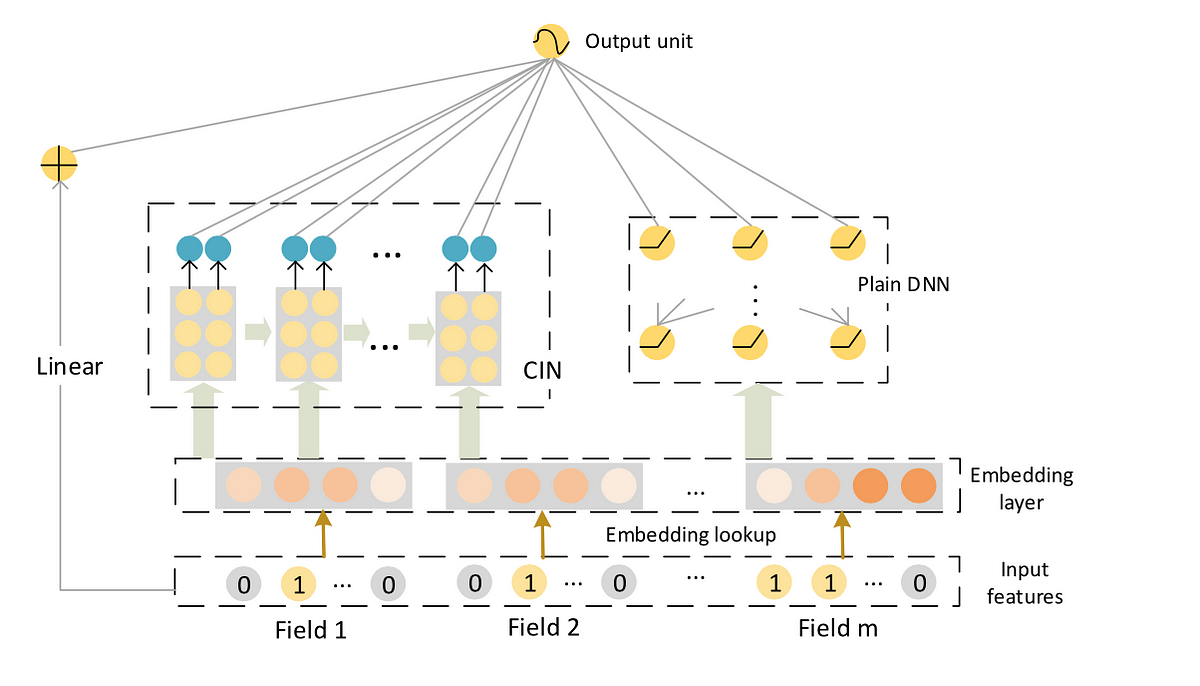

### How it Works

The xDeepFM model functions as follows:
1. Input Processing: Raw features are divided into sparse and dense features. Sparse features are converted into one-hot encoded vectors, while dense features are normalized.
2. Feature Embedding: Both sparse and dense features are transformed into dense vector representations.
3. Parallel Processing:
   * The linear component directly processes raw input features.
   * The DNN learns implicit, bit-wise feature interactions.
   * The CIN generates explicit, vector-wise feature interactions.
4. Combination: The outputs from all three components are combined to produce the final prediction.

* CIN Operation:
   * Creates hidden layers that combine information from the previous layer and the original feature matrix.
   * Uses a mechanism similar to Convolutional Neural Networks (CNNs) to slide weight matrices along feature dimensions.

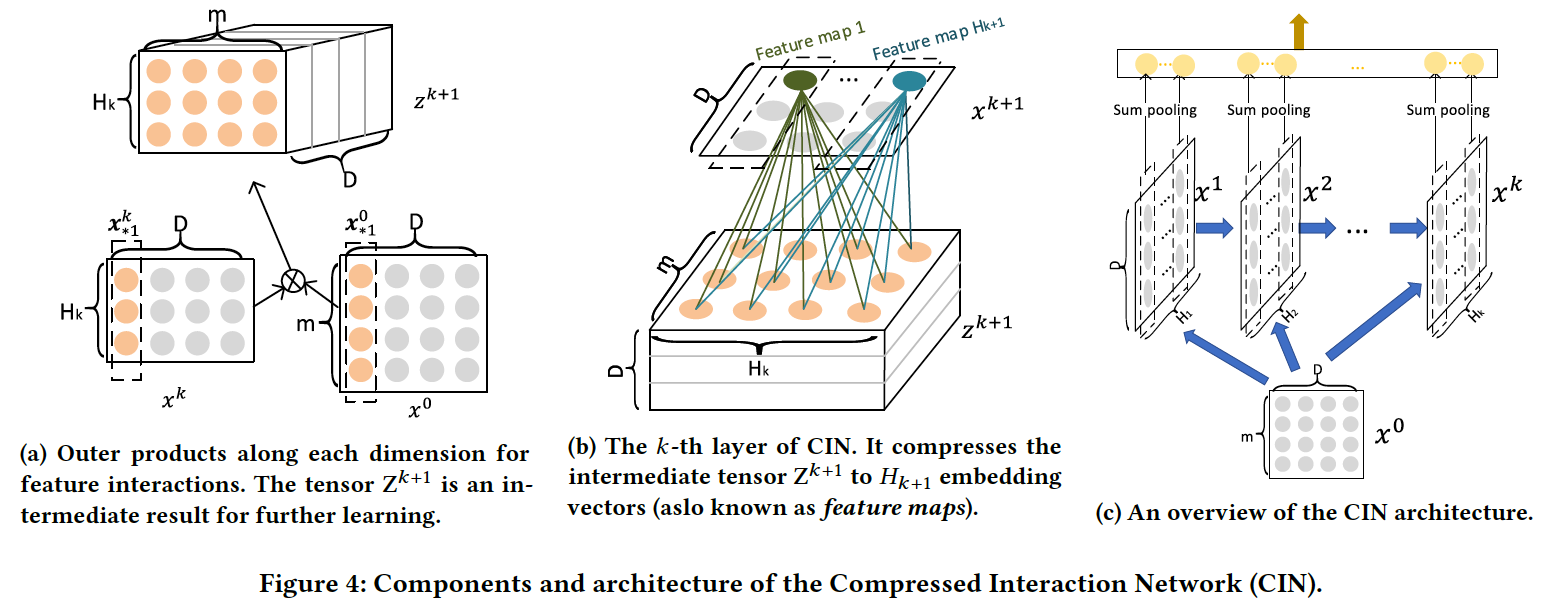

**Explicit feature** interactions in the context of the Compressed Interaction Network (CIN) refer to the direct, intentional modeling of relationships between different features at a vector-wise level.

By explicitly modeling interactions, the CIN component makes it easier to understand which feature combinations are contributing to the model's predictions.

### Key Advantages:

* Learns both low-order and high-order feature interactions.
* Captures explicit interactions at the vector-wise level, unlike traditional DNNs.
* Reduces the need for manual feature engineering.



---


## Features combining

In this section, we will check the more advanced training datasets we created, and see how the different features affect the model training.

#### Including year categories data

In [ ]:
# Preprocess Features
# Define sparse features
sparse_features = ["user_id", "movie_id", "year_category"]

# Encode sparse features
for feat in sparse_features:
    lbe = LabelEncoder()
    year_train_df[feat] = lbe.fit_transform(year_train_df[feat])

fixlen_feature_columns = (
    [SparseFeat(feat, vocabulary_size=year_train_df[feat].nunique(), embedding_dim=4) for feat in sparse_features]
)

linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns

# Generate feature names
feature_names = get_feature_names(fixlen_feature_columns)

In [ ]:
# Define and initialize the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The device is: {device}')
model = xDeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)

train_model(model, device, year_train_df, lr=0.001, epochs=5)

The device is: cuda
Epoch 1/5, Train WRMSE: 0.8791, Validation WRMSE: 0.8573
Epoch 2/5, Train WRMSE: 0.8488, Validation WRMSE: 0.8510
Epoch 3/5, Train WRMSE: 0.8348, Validation WRMSE: 0.8370
Epoch 4/5, Train WRMSE: 0.8137, Validation WRMSE: 0.8294
Epoch 5/5, Train WRMSE: 0.8007, Validation WRMSE: 0.8270


**Conclusions**:

* Final Train WRMSE: 0.8007.
* Final Validation WRMSE: 0.8270 (lowest validation WRMSE across all configurations).
* Generalization: good, with a consistent reduction in train-validation gap.

Notes:
* Adding the year category column improves performance significantly compared to the basic configuration.
* This indicates that the temporal context of movies (age) is an important feature for predicting ratings.

#### Including genres multi-hot data

In [ ]:
# Preprocess Features
# Define sparse and dense features
sparse_features = ["user_id", "movie_id"]
dense_features = [col for col in genre_train_df.columns if col not in sparse_features + ['rating']]

# Encode sparse features
for feat in sparse_features:
    lbe = LabelEncoder()
    genre_train_df[feat] = lbe.fit_transform(genre_train_df[feat])

fixlen_feature_columns = (
    [SparseFeat(feat, vocabulary_size=genre_train_df[feat].nunique(), embedding_dim=4) for feat in sparse_features]
    + [DenseFeat(feat, 1) for feat in dense_features]
)

linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns

# Generate feature names
feature_names = get_feature_names(fixlen_feature_columns)

In [ ]:
# Define and initialize the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The device is: {device}')
model = xDeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)

train_model(model, device, genre_train_df, lr=0.001, epochs=5)

The device is: cuda
Epoch 1/5, Train WRMSE: 0.8809, Validation WRMSE: 0.8584
Epoch 2/5, Train WRMSE: 0.8493, Validation WRMSE: 0.8517
Epoch 3/5, Train WRMSE: 0.8395, Validation WRMSE: 0.8455
Epoch 4/5, Train WRMSE: 0.8307, Validation WRMSE: 0.8403
Epoch 5/5, Train WRMSE: 0.8232, Validation WRMSE: 0.8367


**Conclusions**:

* Final Train WRMSE: 0.8232.
* Final Validation WRMSE: 0.8367.
* Generalization: similar to the baseline.

Notes:
* Including genres doesn't improve much over the baseline.
* This suggests that while genres are relevant, they don't add much value without additional context (like user preferences for genres).

#### Combined both features data

In [ ]:
# Preprocess Features
# Define sparse and dense features
sparse_features = ["user_id", "movie_id", "year_category"]
dense_features = [col for col in combined_train_df.columns if col not in sparse_features + ['rating']]

# Encode sparse features
for feat in sparse_features:
    lbe = LabelEncoder()
    combined_train_df[feat] = lbe.fit_transform(combined_train_df[feat])

fixlen_feature_columns = (
    [SparseFeat(feat, vocabulary_size=combined_train_df[feat].nunique(), embedding_dim=4) for feat in sparse_features]
    + [DenseFeat(feat, 1) for feat in dense_features]
)

linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns

# Generate feature names
feature_names = get_feature_names(fixlen_feature_columns)

In [ ]:
# Define and initialize the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The device is: {device}')
model = xDeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)

train_model(model, device, combined_train_df, lr=0.001, epochs=5)

The device is: cuda
Epoch 1/5, Train WRMSE: 0.8798, Validation WRMSE: 0.8580
Epoch 2/5, Train WRMSE: 0.8485, Validation WRMSE: 0.8491
Epoch 3/5, Train WRMSE: 0.8295, Validation WRMSE: 0.8336
Epoch 4/5, Train WRMSE: 0.8104, Validation WRMSE: 0.8287
Epoch 5/5, Train WRMSE: 0.7995, Validation WRMSE: 0.8273


**Conclusions**:

* Final Train WRMSE: 0.7995 (lowest train WRMSE).
* Final Validation WRMSE: 0.8273 (second-lowest validation WRMSE).
* Generalization: good, with slightly better validation performance than using genres alone.

Notes:
* Combining year category and genres gives the best overall performance.
* The additional information helps the model capture both temporal and categorical aspects of movies.

### Final conclusion:
We will proceed with the combined training dataset, and with the xDeepFM model.



---



## Best hyperparameters

In this section, we will try to find the best model configurations.

#### LR = 0.0008, epochs = 8:

Using the combined dataset with xDeepFM and a learning rate of 0.0008 over 8 epochs achieved the best results:

* Final Train WRMSE: 0.7844.
* Final Validation WRMSE: 0.8267.

A smaller learning rate 0.0005 (not shown beneath but was run before) was too slow to converge, while 0.0008 provided stable improvements without overfitting. The chosen LR ensures faster convergence and better generalization, making it the optimal choice.

In [ ]:
# Preprocess Features
# Define sparse and dense features
sparse_features = ["user_id", "movie_id", "year_category"]
dense_features = [col for col in combined_train_df.columns if col not in sparse_features + ['rating']]

# Encode sparse features
label_encoders = {}
for feat in sparse_features:
    lbe = LabelEncoder()
    label_encoders[feat] = lbe
    combined_train_df[feat] = lbe.fit_transform(combined_train_df[feat])

fixlen_feature_columns = (
    [SparseFeat(feat, vocabulary_size=combined_train_df[feat].nunique(), embedding_dim=8) for feat in sparse_features]
    + [DenseFeat(feat, 1) for feat in dense_features]
)

linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns

# Generate feature names
feature_names = get_feature_names(fixlen_feature_columns)

In [ ]:
# Define and initialize the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The device is: {device}')
model = xDeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)

train_model(model, device, combined_train_df, lr=0.0008, epochs=8)

The device is: cuda
Epoch 1/8, Train WRMSE: 0.8808, Validation WRMSE: 0.8584
Epoch 2/8, Train WRMSE: 0.8497, Validation WRMSE: 0.8522
Epoch 3/8, Train WRMSE: 0.8397, Validation WRMSE: 0.8435
Epoch 4/8, Train WRMSE: 0.8209, Validation WRMSE: 0.8314
Epoch 5/8, Train WRMSE: 0.8051, Validation WRMSE: 0.8280
Epoch 6/8, Train WRMSE: 0.7962, Validation WRMSE: 0.8272
Epoch 7/8, Train WRMSE: 0.7897, Validation WRMSE: 0.8268
Epoch 8/8, Train WRMSE: 0.7844, Validation WRMSE: 0.8267


#### More possible approaches:

1. Embedding dimensions - Larger embeddings can capture more latent interactions, improving performance for complex datasets. In the example below we increased the embedding_dim from 4 to 8.
2. Activation function - can be changed for both CIN and hidden layers. The default for both is 'ReLu'.
3. Hidden Units - the hidden layers structure, can be changed for both CIN and hidden layers, might capture higher-order feature interactions. In the example below we change the dnn hidden layers from [256, 128, 64] (default) to [128, 64, 128].

In [ ]:
# Preprocess Features
# Define sparse and dense features
sparse_features = ["user_id", "movie_id", "year_category"]
dense_features = [col for col in combined_train_df.columns if col not in sparse_features + ['rating']]

# Encode sparse features
label_encoders = {}
for feat in sparse_features:
    lbe = LabelEncoder()
    label_encoders[feat] = lbe
    combined_train_df[feat] = lbe.fit_transform(combined_train_df[feat])

fixlen_feature_columns = (
    [SparseFeat(feat, vocabulary_size=combined_train_df[feat].nunique(), embedding_dim=8) for feat in sparse_features]
    + [DenseFeat(feat, 1) for feat in dense_features]
)

linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns

# Generate feature names
feature_names = get_feature_names(fixlen_feature_columns)

In [ ]:
# Define and initialize the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'The device is: {device}')
model = xDeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device,
                dnn_hidden_units=[128, 64, 128])

train_model(model, device, combined_train_df, lr=0.0008, epochs=8)

The device is: cuda
Epoch 1/8, Train WRMSE: 0.8825, Validation WRMSE: 0.8582
Epoch 2/8, Train WRMSE: 0.8495, Validation WRMSE: 0.8516
Epoch 3/8, Train WRMSE: 0.8332, Validation WRMSE: 0.8359
Epoch 4/8, Train WRMSE: 0.8105, Validation WRMSE: 0.8292
Epoch 5/8, Train WRMSE: 0.7954, Validation WRMSE: 0.8280
Epoch 6/8, Train WRMSE: 0.7818, Validation WRMSE: 0.8289
Epoch 7/8, Train WRMSE: 0.7691, Validation WRMSE: 0.8308
Epoch 8/8, Train WRMSE: 0.7587, Validation WRMSE: 0.8332


### Final conclusion:
We experimented with several combinations of different hyperparameters.

however, we were unable to achieve better results than those obtained in the initial full run.

As demonstrated in the example above, there is significant variability, with the validation results increasing instead of decreasing after 6 epochs.



---


## Submission

In [ ]:
submission_df = pd.read_csv(data_path + "ratings_submission.csv")
submission_df['user_id'], submission_df['movie_id'] = zip(*submission_df['id'].str.split('_').apply(lambda x: (int(x[0]), int(x[1]))))
submission_df = submission_df.merge(movies_df, on='movie_id', how='left')
submission_df.head(5)

,id,prediction,user_id,movie_id,year_category,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0_1188,0,0,1188,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5_7163,0,5,7163,3,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8_460,0,8,460,2,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,9_3705,0,9,3705,2,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,11_2650,0,11,2650,1,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
sparse_features = ["user_id", "movie_id", "year_category"]

# Encode sparse features
for feat in sparse_features:
    lbe = label_encoders[feat]
    submission_df[feat] = lbe.fit_transform(submission_df[feat])

In [ ]:
submission_model_input = {name: submission_df[name].values for name in feature_names}
predictions = model.predict(submission_model_input, batch_size=1024)
submission_df['prediction'] = predictions

In [ ]:
submission_df.head(5)

,id,prediction,user_id,movie_id,year_category,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0_1188,3.834572,0,417,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5_7163,3.865187,1,1389,2,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8_460,4.228735,2,198,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,9_3705,3.300875,3,1086,1,0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,0
4,11_2650,3.862072,4,861,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
output_path = "/kaggle/working/"
submission_df[['id', 'prediction']].to_csv(os.path.join(output_path, "submission.csv"), index=False)